# GIZ NLP Agricultural Keyword Spotter! (17th Place Solution)

### Environments used
* OS - Ubuntu 18.04.5 LTS
* Python - 3.7.4
* CUDA - 11.1
* Libraries from requirements.txt
* Trained on one RTX 2060

In [1]:
## For reproducible results.
## Results may still not be reproducible if different hardware config is used, or the package versions are changed
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
import pandas as pd
import IPython.display as ipd
from fastai2.vision.all import *
import librosa
from matplotlib import pyplot as plt
import numpy as np
import random
import nlpaug
import nlpaug.augmenter.audio as naa
import nlpaug.augmenter.spectrogram as nas
import warnings
from pathlib import PosixPath
from audiomentations import Compose, AddGaussianNoise, PitchShift, AddShortNoises, AddBackgroundNoise
warnings.filterwarnings("ignore")
import gc
# matplotlib.rc('image', cmap='Greys')

## Resampling input audio files (Pre-processing)
credits:https://gist.github.com/pmwaniki/fece16fff8f53ddb33d13df51054ab02

In [2]:
def mkdir(file): #creating folders
    command = ['mkdir', '-p', os.path.join('wav1/',file.parent)]
    subprocess.run(command,stdout=subprocess.PIPE,stdin=subprocess.PIPE)

In [3]:
def convert_sr(file):# resampling
    command = ['ffmpeg', '-i', os.path.join(file), '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '44100', os.path.join('wav1/',file)]
    subprocess.run(command,stdout=subprocess.PIPE,stdin=subprocess.PIPE)

In [4]:
for x in get_files('nlp_keywords_29Oct2020/'):
    mkdir(x) 
for x in get_files('AdditionalUtterances/'):
    mkdir(x)
!mkdir -p wav1/audio_files
for x in get_files('nlp_keywords_29Oct2020/'):
    convert_sr(x)
for x in get_files('AdditionalUtterances/'):
    convert_sr(x)
for x in get_files('audio_files/'):
    convert_sr(x)

3min 39s ± 12.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
train = pd.read_csv('Train.csv')
train['fn'] = 'wav1/' + train['fn']

### Adding additional Train data to existing Train csv file 

In [6]:
def get_x(path):
    x = get_files(path,extensions='.wav')
    return L((str(y),y.parent.name) for y in x)

In [7]:
df = pd.DataFrame(get_x('wav1/nlp_keywords_29Oct2020/nlp_keywords/'),columns=['fn','label'])
df1 = pd.DataFrame(get_x('wav1/AdditionalUtterances/latest_keywords/'),columns=['fn','label'])
train = pd.concat([train,df,df1],ignore_index=True)
del df
del df1
gc.collect()

7

Making 'is_valid' feature False to use complete train data for training the model

In [8]:
train['is_valid'] = False

In [9]:
ss = pd.read_csv('SampleSubmission.csv')

## Reading audio file with different augmentations
- Credits:
    * https://github.com/vlomme/Birdcall-Identification-competition
    * https://pypi.org/project/nlpaug/
    * https://github.com/iver56/audiomentations

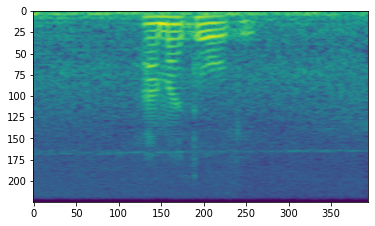

In [10]:
def random_power(images, power = 1.5, c= 0.7):
    images = images - images.min()
    images = images/(images.max()+0.0000001)
    images = images**(random.random()*power + c)
    return images
def mono_to_color1(X: np.ndarray,
                  mean=0.5,
                  std=0.5,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
#     if X.ndim==2 : X = np.expand_dims(X,2)
#     X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def im_from_audio(fn, sample_rate=16000, window_length=0.005, window_step=0.0045, NFFT=1292):
  
  # Load the audio into an array (signal) at the specified sample rate
  signal, sr = librosa.load(fn, sr=sample_rate,res_type="kaiser_fast")
  n_mels = 225
  level_noise = 0.05

  rand = random.random()
  augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),

    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#The sound files used for background and short noise downloaded from freesound.org

#street-scene-1 by saphe
#street-scene-3 by saphe
#high-street-of-gandia-valencia-spain by jormarp
#city-park-tel-aviv-israel by yonts

#URLs:

#http://freesound.org/people/saphe/sounds/150993/
#http://freesound.org/people/saphe/sounds/173955/
#http://freesound.org/people/Jormarp/sounds/207208/
#http://freesound.org/people/yonts/sounds/268903/
      
      # Cropped original sound to 4seconds
      AddShortNoises(sounds_path=PosixPath('bgn/')), 
      AddBackgroundNoise(sounds_path=PosixPath('bgn/'),p=1.0)

    ])
  signal = augment(samples=signal,sample_rate=sample_rate)

# # Speed Augmenter
  if rand<0.5:
    aug = naa.SpeedAug()
    signal = aug.augment(signal)

  spectr = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, n_fft=NFFT, win_length = NFFT,hop_length = 100)# ,fmin = 300)

  images = np.zeros((n_mels, spectr.shape[1])).astype(np.float32)

  # Change the contrast 
  mel = random_power(spectr, power = 3, c= 0.5)
  # Mix the signal
  div_coef = 100
  
  images = images + mel*(random.random() * div_coef + 1)

  images = images + mel/(mel.max()+0.0000001)*(random.random()*1+0.5)*images.max()
        
        # In db and normalize
  images = librosa.power_to_db(spectr.astype(np.float32), ref=np.max)
  images = (images+80)/80
        
        # Add noise
        # Add white noise            
  if random.random()<0.9:
    images = images + (np.random.sample((n_mels,spectr.shape[1])).astype(np.float32)+9) * images.mean() * level_noise * (np.random.sample() + 0.3)
        
#         Add pink noise 
  if random.random()<0.9:
    r = random.randint(1,n_mels)
    pink_noise = np.array([np.concatenate((1 - np.arange(r)/r,np.zeros(n_mels-r)))]).T
    images = images + (np.random.sample((n_mels, spectr.shape[1])).astype(np.float32)+9) * 2  * images.mean() * level_noise * (np.random.sample() + 0.3)
        
        # Add bandpass noise
  if random.random()<0.9:
    a = random.randint(0, n_mels//2)
    b = random.randint(a+20, n_mels)
    images[a:b,:] = images[a:b,:] + (np.random.sample((b-a,spectr.shape[1])).astype(np.float32)+9) * 0.05 * images.mean() * level_noise  * (np.random.sample() + 0.3)
  
  if random.random()<0.5:
      images = images - images.min()
      r = random.randint(spectr.shape[0]//2,spectr.shape[0])
      x = random.random()/2
      pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(spectr.shape[0]-r)-x+1))]).T
      images = images*pink_noise
      images = images/images.max()
  rand = random.random()
#Frequency Masking
  if rand<0.5:
    aug = nas.FrequencyMaskingAug(zone=(0, 1))
    images = aug.substitute(images)

  images = mono_to_color1(images)

  return images

plt.imshow(im_from_audio('wav1/AdditionalUtterances/latest_keywords/amatooke/2497942026ef4d7e97d47fc2738d7c27_881369e0729e474b8b642a60dac1af55.wav'))

## Building dataloader with FastAI Datablock API
- Credits : https://docs.fast.ai/

In [11]:
random_seed(19)
import pdb
def get_x(fn):
  spectrogram = im_from_audio(fn.fn) # Converting audio file to image
  return spectrogram

def get_y(fn):
  return train.loc[train.fn == fn.fn].label.values[0] # Labels for corresponding 

def get_fns(_):
  return train # train csv file

In [12]:
def get_dls(bs,size):
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_fns, # getting items from train csv 
        get_x=get_x, # Image file from audio
        get_y=get_y, # Labels
        splitter=ColSplitter(), # No valid data, 
        item_tfms=Resize(224,size),# resizing image
        batch_tfms=[*aug_transforms(size=(224,size), min_scale=0.85,do_flip=False,p_affine=0,max_rotate=0,
        max_zoom=0,max_warp=0,p_lighting=0,
        pad_mode='zeros')]
)
    return dblock.dataloaders(Path(''), bs=bs) #creating dataloader

## Reading Test data audio file

In [14]:
def im_from_audiov(fn, sample_rate=16000, window_length=0.005, window_step=0.0045, NFFT=1292):
    n_mels = 225
    signal, sr = librosa.load(fn, sr=sample_rate,res_type="kaiser_fast")
    spectr = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, n_fft=NFFT, win_length = NFFT,hop_length = 100)# ,fmin = 300)
    spectr = librosa.power_to_db(spectr.astype(np.float32), amin=1e-7, ref=np.max)
    spectr = ((spectr+80)/80)
    images = mono_to_color1(spectr)
    return images
def get_t(fn):
  spectrogram = im_from_audiov(fn) #Converts audio file into image
  return spectrogram
def get_fns_t(_):
  return [get_t('wav1/'+i) for i in ss['fn'].values] # test data from sample submission csv

### Below are the model architectures with pretrained weights used

In [13]:
# learn = load_learner('exp1', cpu=False)
model = {}
models = [resnet18,resnet34,resnet50,densenet121,densenet169]
# pth = ['resnet18','resnet34','resnet50','densenet121']

## Training the model and getting prediction for test data set
- Credits : https://docs.fast.ai/

In [15]:
for i,a in enumerate(models):
    # changing batch size to fit into 6GB GPU
    if a is densenet121:dls = get_dls(16,512) 
    elif a is densenet169:dls = get_dls(12,512)
    else:dls = get_dls(20,512)
    learn = cnn_learner(dls,models[i])# creating leaner with architecture and dataloader
    learn.fit_one_cycle(3, 3e-3)# freezing earlier layers and trained for 3 epochs
    learn.fine_tune(116,wd=0.2,cbs=[SaveModelCallback(monitor='train_loss')]) # unfreezing after 1 epoch and trained for 116 epochs
    print(str(a)+' Model completed')
#     learn.load(pth[i])
    tdl = learn.dls.test_dl(get_fns_t(_), order=True) # get test dataloader
    learn.epoch = 0
    preds,targs = learn.tta(dl=tdl,n=5) # test time augmentation
    model[i] = preds # saving the prediction
    del learn
    gc.collect()
# Trained with 1 epoch for sample run

epoch,train_loss,valid_loss,time
0,6.373656,None,08:39


epoch,train_loss,valid_loss,time
0,5.997389,None,08:29


Better model found at epoch 0 with train_loss value: 5.99738883972168.


epoch,train_loss,valid_loss,time
0,5.571489,None,08:08


Better model found at epoch 0 with train_loss value: 5.571488857269287.
<function resnet18 at 0x7f0076d0a4d0> Model completed


epoch,train_loss,valid_loss,time
0,6.305283,None,08:32


epoch,train_loss,valid_loss,time
0,6.008992,None,08:29


Better model found at epoch 0 with train_loss value: 6.0089921951293945.


epoch,train_loss,valid_loss,time
0,5.546382,None,08:58


Better model found at epoch 0 with train_loss value: 5.546382427215576.
<function resnet34 at 0x7f0076d0a560> Model completed


epoch,train_loss,valid_loss,time
0,6.314536,None,08:31


epoch,train_loss,valid_loss,time
0,6.005623,None,08:42


Better model found at epoch 0 with train_loss value: 6.005622863769531.


epoch,train_loss,valid_loss,time
0,5.495543,None,08:22


Better model found at epoch 0 with train_loss value: 5.495543003082275.
<function resnet50 at 0x7f0076d0a5f0> Model completed


epoch,train_loss,valid_loss,time
0,6.181991,None,08:38


epoch,train_loss,valid_loss,time
0,5.977781,None,08:44


Better model found at epoch 0 with train_loss value: 5.977780818939209.


epoch,train_loss,valid_loss,time
0,5.488944,None,08:44


Better model found at epoch 0 with train_loss value: 5.488943576812744.
<function densenet121 at 0x7f0076d26dd0> Model completed


epoch,train_loss,valid_loss,time
0,6.077588,None,08:59


epoch,train_loss,valid_loss,time
0,5.934541,None,08:53


Better model found at epoch 0 with train_loss value: 5.934540748596191.


epoch,train_loss,valid_loss,time
0,5.285256,None,10:50


Better model found at epoch 0 with train_loss value: 5.285256385803223.
<function densenet169 at 0x7f0076d26ef0> Model completed


## Ensembling

In [16]:
# Taking mean 
mean = np.mean((np.stack([model[0],model[1],model[2],model[3],model[4]])),axis=0)

In [17]:
dls.vocab # The class names

(#193) ['Pump','Spinach','abalimi','afukirira','agriculture','akammwanyi','akamonde','akasaanyi','akatunda','akatungulu'...]

## Saving the prediction

In [18]:
# Save the predictions in the required format
for i, label in enumerate(dls.vocab):
  ss[label] = [t[i] for t in mean]
ss.head()

,fn,maize streak virus,disease,okukkoola,muwogo,mpeke,mucungwa,greens,garden,mango,...,kasaanyi,suckers,insects,fertilizer,nakavundira,ekiwojjolo,akawuka,ddagala,ebiwojjolo,obutungulu
0,audio_files/00118N3.wav,0.002733,0.002405,0.004805,0.003777,0.019122,0.002385,0.002682,0.003634,0.002441,...,0.002192,0.003688,0.003438,0.003456,0.003484,0.006438,0.011642,0.003195,0.007830,0.005407
1,audio_files/00P0NMV.wav,0.001837,0.003004,0.003564,0.002017,0.001639,0.005469,0.002096,0.001918,0.037650,...,0.030281,0.002192,0.001458,0.011342,0.013962,0.002754,0.007252,0.006362,0.003455,0.004007
2,audio_files/01QEEZI.wav,0.003397,0.002386,0.004430,0.004637,0.003990,0.006283,0.002068,0.003329,0.003521,...,0.006431,0.002539,0.002329,0.006317,0.004356,0.007500,0.003339,0.005807,0.010631,0.006139
3,audio_files/037YAED.wav,0.001949,0.003747,0.005462,0.002574,0.002522,0.002909,0.002071,0.002547,0.013899,...,0.052571,0.002343,0.001427,0.005265,0.014195,0.003070,0.015049,0.008330,0.003358,0.004483
4,audio_files/0382N0Y.wav,0.002708,0.003174,0.002994,0.003021,0.006632,0.005526,0.002259,0.002364,0.013330,...,0.002651,0.002811,0.002893,0.011389,0.002894,0.006736,0.005491,0.004912,0.002607,0.003242


In [19]:
ss.to_csv('Submission_f.csv', index=False)